<a href="https://colab.research.google.com/github/esferita006/Codigos_de_varias_materias/blob/main/CAPM_ejercicio_2_finanzas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="Teal" face="Comic Sans MS,arial">
  <h1 align="center"><i>EJERCICIOs de CAPM</i></h1>
</font>

<font color="Black" face="Comic Sans MS,arial">
  <h5 align="center"><i>Acontinuacon se presentan algunos ejercicios de finanzas </i></h5>
</font>

In [ ]:
# Importar las bibliotecas necesarias
import numpy as np  # Biblioteca para operaciones numéricas en arrays
import pandas as pd  # Biblioteca para manipulación y análisis de datos en forma de DataFrames
import matplotlib as mpl  # Biblioteca para crear visualizaciones gráficas
import scipy  # Biblioteca que contiene diversas funciones y herramientas para la ciencia y la ingeniería
import importlib  # Módulo para importar de forma dinámica otros módulos
import matplotlib.pyplot as plt  # Sub-módulo de matplotlib para trazar gráficos
from scipy.stats import skew, kurtosis, chi2, linregress  # Módulos de scipy para cálculos estadísticos y regresión lineal
from scipy.optimize import minimize  # Módulo de scipy para optimización numérica
from numpy import linalg as LA  # Sub-módulo de numpy para álgebra lineal
import yfinance as yf  # Biblioteca para obtener datos financieros de Yahoo Finance
import datetime  # Módulo para trabajar con fechas y horas
from datetime import datetime, timedelta  # Importar específicamente datetime y timedelta desde el módulo

# El código importa varias bibliotecas esenciales para el análisis de datos, visualización, cálculos estadísticos,
# optimización y obtención de datos financieros.


In [ ]:
def load_timeseries(ric, start=None, end=None):
    # Vamos a suponer que estan vacias ambas fechas, y tomamos un año de historia a partir de hoy
    if (end== None)&(start== None):
        date_init = datetime.today() - timedelta(days=365)
        date_init = date_init.strftime("%Y-%m-%d")
        table_raw = yf.download(ric, start=date_init, progress=False)

    elif (end!= None)&(start== None):
        date_init = datetime.strptime(end, "%Y-%m-%d")-timedelta(days=2)
        date_init = start.strftime("%Y-%m-%d")
        table_raw = yf.download(ric, start=date_init, progress=False)
    elif (end== None)&(start!= None):
        table_raw = yf.download(ric, start=start, progress=False)
    else:
        if end<start:
            print('estan mal fechas')
            return None
        else:
            table_raw = yf.download(ric, start=start, end=end, progress=False)

    t = pd.DataFrame()
    t['date'] = pd.to_datetime(table_raw.index, dayfirst=True)
    t['close'] = table_raw['Close'].values
    t.sort_values(by='date', ascending=True)
    t['close_previous'] = t['close'].shift(1)
    t['return_close'] = t['close']/t['close_previous'] - 1
    t = t.dropna()
    t = t.reset_index(drop=True)
    x = t['return_close'].values # returns as array
    x_str = 'Market data of '+ ric # label e.g. ric
    return x, x_str, t

def plot_histogram(vec_returns, x_str):
  # plot histogram
  label_x = plot_str(vec_returns)
  plt.figure()
  plt.hist(vec_returns, bins=100)
  plt.title('Histogram ' + x_str)
  plt.xlabel(str(label_x))
  plt.show()

def compute(vec_returns):
  # self.size = self.dataframe.shape[0]
  nb_rows = len(vec_returns)
  mean = np.mean(vec_returns)
  std = np.std(vec_returns) # volatility
  skewness = skew(vec_returns)
  kurt = kurtosis(vec_returns) # excess kurtosis
  sharpe = mean / std * np.sqrt(252) # annualised
  jb_stat = nb_rows /6*(skewness**2 + 1/4*kurt**2)
  p_value = 1 - chi2.cdf(jb_stat, df=2)
  is_normal = (p_value > 0.05) # equivalently jb < 6
  # var_95 = np.percentile(vec_returns,5)
  # cvar_95 = np.mean(vec_returns[vec_returns <= var_95])
  percentile_25 = percentile(vec_returns, 25)
  median = np.median(vec_returns)
  percentile_75 = percentile(vec_returns, 75)
  return     mean, std, skewness, kurt, sharpe, jb_stat, p_value, \
      is_normal, percentile_25, median, percentile_75

def percentile(vec_returns, pct):
    percentile = np.percentile(vec_returns, pct)
    return percentile

def plot_str(vec_returns):
    nb_decimals = 4
    mean, std, skew, kurtosis, sharpe, jb_stat, p_value, \
        is_normal, percentile_25, median, percentile_75 = compute(vec_returns)

    plot_str = 'mean ' + str(np.round(mean,nb_decimals))\
        + ' | std dev ' + str(np.round(std,nb_decimals))\
        + ' | skewness ' + str(np.round(skew,nb_decimals))\
        + '| kurtosis ' + str(np.round(kurtosis,nb_decimals)) + '\n' \
        + 'Jarque Bera ' + str(np.round(jb_stat,nb_decimals))\
        + ' | p-value ' + str(np.round(p_value,nb_decimals))\
        + ' | is normal ' + str(is_normal) + '\n'\
        + ' Sharpe ratio annual ' + str(np.round(sharpe,nb_decimals))+ '\n' \
        + ' percentile 25% ' + str(np.round(percentile_25,nb_decimals))\
        + ' | median ' + str(np.round(median,nb_decimals))\
        + ' | percentile 75% ' + str(np.round(percentile_75,nb_decimals))\

    return plot_str

def plot_timeseries_price(t, ric):
    # plot timeseries of price
    plt.figure()
    plt.plot(t['date'],t['close'])
    plt.title('Time series real prices ' + ric)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.show()


### Rendimientos

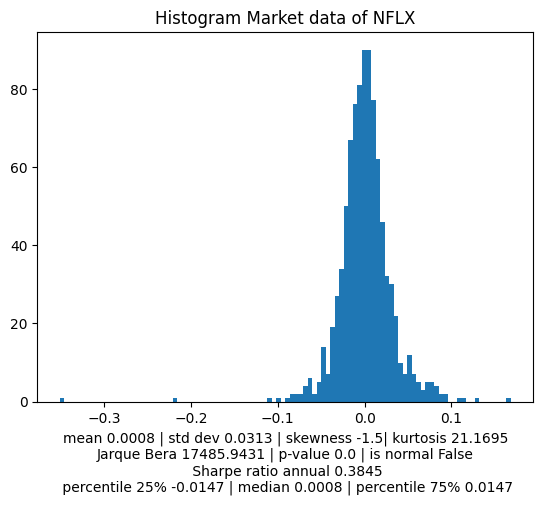

In [ ]:
ric = 'NFLX' #'^GSPC' # SPY NFLX

x, x_str, t = load_timeseries(ric, start='2020-01-01')

plot_histogram(vec_returns = x, x_str = x_str)

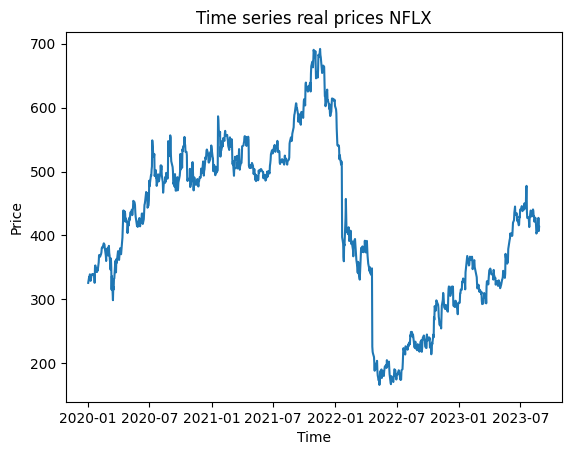

In [ ]:
plot_timeseries_price(t = t, ric = ric)

### CAPM

In [ ]:
def synchronise_timeseries(benchmark, ric):
    # loading data from csv or Excel file
    x1, str1, t1 = load_timeseries(benchmark)
    x2, str2, t2 = load_timeseries(ric)
    # synchronize timestamps
    timestamp1 = list(t1['date'].values)
    timestamp2 = list(t2['date'].values)
    timestamps = list(set(timestamp1) & set(timestamp2))
    # synchronised time series for x1 or ric
    t1_sync = t1[t1['date'].isin(timestamps)]
    t1_sync.sort_values(by='date', ascending=True)
    t1_sync = t1_sync.reset_index(drop=True)
    # synchronised time series for x2 or benchmark
    t2_sync = t2[t2['date'].isin(timestamps)]
    t2_sync.sort_values(by='date', ascending=True)
    t2_sync = t2_sync.reset_index(drop=True)
    # table of returns for ric and benchmark
    t = pd.DataFrame()
    t['date'] = t1_sync['date']
    t['price_1'] = t1_sync['close'] # price benchmark
    t['price_2'] = t2_sync['close'] # price ric

    ### added previous close ###
    t['price_1_previous'] = t1_sync['close_previous'] # previous close benchmark
    t['price_2_previous'] = t2_sync['close_previous'] # previous close ric

    t['return_1'] = t1_sync['return_close'] # return benchmark
    t['return_2'] = t2_sync['return_close'] # return ric
    # compute vectors of returns
    returns_benchmark = t['return_1'].values # variable x
    returns_ric = t['return_2'].values # variable y
    return returns_benchmark, returns_ric, t # x, y, t



def compute_capm(returns_benchmark, returns_ric):
    nb_decimals = 4
    # linear regression of ric with respect to benchmark
    slope, intercept, r_value, p_value, std_err = linregress(returns_benchmark, returns_ric)
    beta = np.round(slope, nb_decimals)
    alpha = np.round(intercept, nb_decimals)
    p_value = np.round(p_value, nb_decimals)
    null_hypothesis = p_value > 0.05 # p_value < 0.05 --> reject null hypothesis
    r_value = np.round(r_value, nb_decimals) # correlation coefficient
    r_squared = np.round(r_value**2, nb_decimals) # pct of variance of y explained by x
    correlation = r_value
    predictor_linreg = alpha + beta*returns_benchmark
    return slope, intercept, r_value, p_value, std_err, beta, alpha, p_value, null_hypothesis, r_value, \
      r_squared, correlation, predictor_linreg

def scatterplot(returns_benchmark, returns_ric):
    # scatterplot of returns
    slope, intercept, r_value, p_value, std_err, beta, alpha, p_value, null_hypothesis, r_value, \
      r_squared, correlation, predictor_linreg = compute_capm(returns_benchmark, returns_ric)

    str_self = 'Linear regression | ric ' + ric\
    + ' | benchmark ' + benchmark + '\n'\
    + 'alpha (intercept) ' + str(alpha)\
    + ' | beta (slope) ' + str(beta) + '\n'\
    + 'p-value ' + str(p_value)\
    + ' | null hypothesis ' + str(null_hypothesis) + '\n'\
    + 'r-value (correlation) ' + str(r_value)\
    + ' | r-squared ' + str(r_squared)

    str_title = 'Scatterplot of returns' + '\n' + str_self
    plt.figure()
    plt.title(str_title)
    plt.scatter(returns_benchmark, returns_ric)
    plt.plot(returns_benchmark, predictor_linreg, color='green')
    plt.ylabel(ric)
    plt.xlabel(benchmark)
    plt.grid()
    plt.show()

#**r = α + β * r<sub>m</sub> + c**



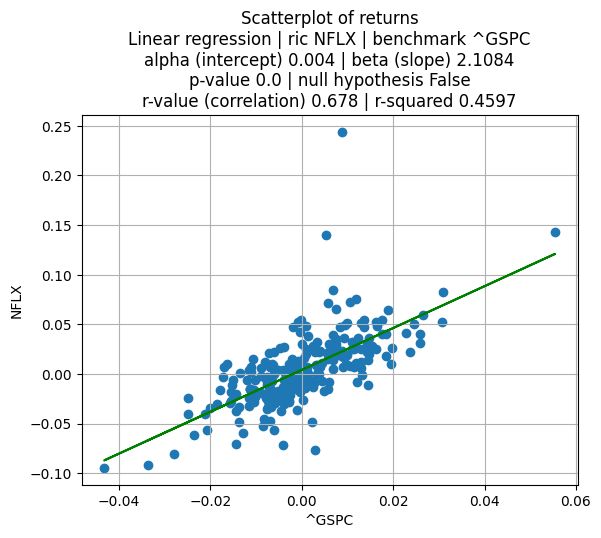

In [ ]:
benchmark = '^GSPC' # STOCXX50E
security = 'NVDA' # 'NFLX' AAPL NVDA META ^VIX XOP EEM

returns_benchmark, returns_ric, t = synchronise_timeseries(benchmark, security)

scatterplot(returns_benchmark, returns_ric)

### CAPM Cobertura

Cobertura con dos activos. Suponemos que tenemos una posición $S_0$ de un activo, entonces buscamos cubrir la posición a través de $S_1$ y $S_2$

$S_0 + S_1 + S_2 = 0 $, delta neutral

$\beta_0 S_0 + \beta_1 S_1 + \beta_2 S_2 = 0 $, beta neutral

$
\begin{pmatrix}
  1 & 1  \\
  \beta_1 & \beta_2 \\
\end{pmatrix}
\begin{pmatrix} S_1\\ S_2\\ \end{pmatrix} = \begin{pmatrix} -S_0\\ -\beta_0 S_0\\ \end{pmatrix}
$

$ \therefore
\begin{pmatrix} S_1\\ S_2\\ \end{pmatrix} = \begin{pmatrix}
  1 & 1  \\
  \beta_1 & \beta_2 \\
\end{pmatrix}^{-1}
\begin{pmatrix} -S_0\\ -\beta_0 S_0\\ \end{pmatrix}
$

In [ ]:
def compute_beta(benchmark, ric):
    returns_benchmark, returns_ric, t = synchronise_timeseries(benchmark, ric)
    slope, intercept, r_value, p_value, std_err, beta, alpha, p_value, null_hypothesis, r_value, \
      r_squared, correlation, predictor_linreg = compute_capm(returns_benchmark, returns_ric)

    return beta

In [ ]:
ric = 'ba' #'BBVA.MC'
benchmark = '^STOXX'  #     '^STOXX'
hedge_rics = ['SAN.MC', 'REP.MC']
delta = 10  #10 M usd

beta = compute_beta(benchmark, ric)
beta_usd = beta*delta
betas = [compute_beta(benchmark, hedge_ric) \
                        for hedge_ric in hedge_rics]

betas = np.asarray(betas).reshape([len(hedge_rics),1])

dataframe = pd.DataFrame()
dataframe['ric'] = hedge_rics
dataframe['beta'] = betas

print('------')
print('Input portfolio:')
print('Delta mnUSD for ' + ric + ' is ' + str(delta))
print('Beta for ' + ric + ' vs ' + benchmark + ' is ' + str(beta))
print('Beta mnUSD for ' + ric + ' vs ' + benchmark + ' is ' + str(beta_usd))
print('------')
print('Input hedges:')
for n in range(dataframe.shape[0]):
    print('Beta for hedge[' + str(n) + '] = ' + dataframe['ric'][n] \
          + ' vs ' + benchmark + ' is ' + str(dataframe['beta'][n]))



------
Input portfolio:
Delta mnUSD for ba is 10
Beta for ba vs ^STOXX is 0.9465
Beta mnUSD for ba vs ^STOXX is 9.465
------
Input hedges:
Beta for hedge[0] = SAN.MC vs ^STOXX is 1.3573
Beta for hedge[1] = REP.MC vs ^STOXX is 0.682


In [ ]:
size = dataframe.shape[0]
deltas = np.ones([size,1])
targets = -np.array([[delta],[beta_usd]])
mtx = np.transpose(np.column_stack((deltas, betas)))
optimal_hedge = np.linalg.inv(mtx).dot(targets)
dataframe['delta'] = optimal_hedge
dataframe['beta_usd'] = betas*optimal_hedge
hedge_delta = np.sum(dataframe['delta'])
hedge_beta_usd = np.sum(dataframe['beta_usd']) #np.transpose(betas).dot(optimal_hedge).item()


In [ ]:
print('------')
# print('Optimisation result | ' + optimisation_type + ':')
print('Optimisation result :')
print('------')
print('Delta: ' + str(delta))
print('Beta USD: ' + str(beta_usd))
print('------')
print('Hedge delta: ' + str(hedge_delta))
print('Hedge beta USD: ' + str(hedge_beta_usd))
print('------')
print('Betas for the hedge:')
print(betas)
print('------')
print('Optimal hedge:')
print(optimal_hedge)


------
Optimisation result :
------
Delta: 10
Beta USD: 9.465
------
Hedge delta: -10.0
Hedge beta USD: -9.465
------
Betas for the hedge:
[[1.3573]
 [0.682 ]]
------
Optimal hedge:
[[-3.91677773]
 [-6.08322227]]
